In [1]:
# 1) Imports
import tensorflow as tf
import pandas as pd
import numpy as np

import seaborn as sns
from scipy import stats

ModuleNotFoundError: No module named 'tensorflow'

In [6]:
# Start by loading large file. Fill NaN values with 0. data/GSE82221 GPL10558_DiffExpr_Results
# Results in format:
"""
Gene Name, Sample 1 Expression, Sample 2 Expression, Sample 3 Expression, ...
ACC1, 0.534, -0.123, 3.23, ...
"""
data = pd.read_excel("./differential_expression_remove.xlsx").fillna(0).set_index("Unnamed: 0")
data

,GSM260887,GSM260890,GSM260892,GSM260895,GSM260898,GSM260901,GSM260904,GSM260907,GSM260910,GSM260915,...,GSM2159874_GSM2186713,GSM2159875_GSM2186714,GSM2159876_GSM2186715,GSM2159877_GSM2186716,GSM2159878_GSM2186717,GSM2159879_GSM2186718,GSM2159880_GSM2186719,GSM2159881_GSM2186720,GSM2159882_GSM2186721,GSM2159883_GSM2186722
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAMP,7.987898,8.146919,7.872645,7.597145,7.869418,7.444805,8.061699,7.710792,8.071035,7.879941,...,7.706938,6.988278,7.735954,6.546169,6.381689,6.501416,6.448938,7.624701,6.814338,7.460934
AAR2,8.200976,8.173634,8.092444,8.232831,8.162719,8.381002,8.054371,8.047274,8.136662,8.129697,...,9.265841,8.674259,9.007166,8.954978,8.511553,8.557573,8.656798,8.830969,8.607525,9.414040
AARS,9.245106,9.191260,8.986071,8.918300,9.207463,9.268225,9.199175,9.253299,9.036789,9.088280,...,10.414229,10.730855,10.750850,10.874624,10.770068,9.892971,10.443322,10.225672,10.087484,10.358513
AASDHPPT,7.520883,6.788238,6.575260,7.036747,7.508357,7.777682,8.008363,7.840830,6.934142,7.570956,...,8.514694,8.001638,8.384378,9.119604,8.370917,8.211381,8.209006,8.180443,8.462781,8.721967
AATF,8.703046,8.915998,8.274914,8.792234,8.887310,8.809920,8.405534,8.165832,8.665352,8.768472,...,8.646712,8.836878,8.937474,8.409900,8.654601,8.622416,9.108593,8.943129,8.857860,8.728813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN32,7.164279,7.165870,7.246966,7.115276,6.924431,7.053697,6.918531,6.969792,7.182219,7.075128,...,8.936343,8.595110,8.542057,8.930000,8.044748,6.907201,8.534103,8.306572,8.378163,8.841689
ZSWIM8,6.506561,6.879131,7.336054,6.974795,5.767546,5.764456,6.070139,5.830443,6.533614,6.444665,...,8.885271,9.064544,8.282370,9.125560,9.027318,8.699951,9.460827,9.210849,8.658267,7.929616
ZXDC,7.895829,7.627829,7.018347,7.375847,8.238326,8.458064,7.630709,7.715188,7.934763,7.740201,...,6.579478,6.903806,6.704035,6.123917,6.645395,6.257242,6.710593,6.748697,6.597415,6.092526


In [7]:
# Use metadata to get which samples are healthy and not healthy.
metadata = pd.read_csv(open("metadata.tsv", "r"), delimiter="\t").set_index("Sample")

train_input, train_output = np.zeros((len(data.columns), len(data.index))), np.zeros((len(data.columns), 2))
one_hot_output = np.zeros(len(data.columns))

# Graph this info
metadata_info = []

p_values = []

# Now iterate through each column of our data, and place it into final_data.
options = list(set(metadata["Condition"]))
for index, sample in enumerate(data.columns):
    # A specific sample will have gene expression values, and then whether they're sick or not.
    # Put into input gene expression values...
    train_input[index] = (data[sample].to_numpy())
    # And put into output whether this person is sick or not (look up user in metadata)
    categorical = np.zeros(len(options))
    categorical[options.index(metadata.loc[sample]["Condition"])] = 1
    
    metadata_info.append(metadata.loc[sample]["Tissue"])
    
    train_output[index] = categorical
    one_hot_output[index] = options.index(metadata.loc[sample]["Condition"])

train_input = stats.zscore(train_input)

In [8]:
tissue_types = set(metadata_info)
tissue_counts = {t: 0 for t in tissue_types}

for i in metadata_info:
    tissue_counts[i] += 1

tissue_counts

{'Whole blood': 387, 'Skin': 14, 'Peripheral blood': 768}

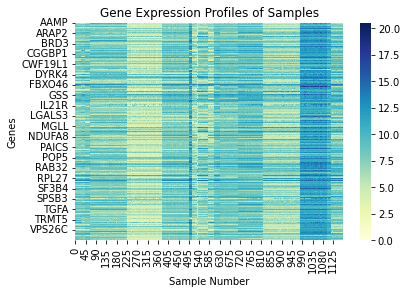

In [9]:
# Observe output and its shape
# For heatmap, order training data by healthiness and sickness

data_rem_names = data.rename(columns = { col: i for i, col in enumerate(data.columns) })
data_rem_names.index.rename("Genes", inplace=True)

plot = sns.heatmap(data_rem_names, cmap="YlGnBu")
plot.set(title= "Gene Expression Profiles of Samples", xlabel="Sample Number")
plot.get_figure().savefig("gene_expression.png")

In [10]:
# Start by creating dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_input[50:], train_output[50:])).shuffle(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((train_input[:50], train_output[:50])).batch(32).cache().prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=(train_input.shape[1],)),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax') # [sick probability, healthy probability]
])

# Create model + compile
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["binaryaccuracy", "mse"])

2023-01-11 16:55:06.642751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-11 16:55:06.643388: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-11 16:55:06.644066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (athena): /proc/driver/nvidia/version does not exist
2023-01-11 16:55:06.670045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                49120     
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
Total params: 49,802
Trainable params: 49,802
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(train_input, train_output, epochs = 100, validation_data=test_dataset)

Epoch 1/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9820 - mse: 0.0119 - val_loss: 0.2282 - val_accuracy: 0.9000 - val_mse: 0.0695
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.9846 - mse: 0.0098 - val_loss: 0.0022 - val_accuracy: 1.0000 - val_mse: 6.0921e-05
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.9932 - mse: 0.0045 - val_loss: 0.0019 - val_accuracy: 1.0000 - val_mse: 1.9335e-05
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9957 - mse: 0.0032 - val_loss: 0.0011 - val_accuracy: 1.0000 - val_mse: 9.2149e-06
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9914 - mse: 0.0069 - val_loss: 0.0062 - val_accuracy: 1.0000 - val_mse: 4.9842e-04
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 0.0367 - accuracy: 0.9863 - mse: 0.0109 - val_

In [16]:
model.predict(train_input)

37/37 [==============================] - 0s 1ms/step


array([[1.7874348e-05, 9.9998206e-01],
       [3.3741363e-04, 9.9966264e-01],
       [3.1238704e-04, 9.9968767e-01],
       ...,
       [9.9999863e-01, 1.3664149e-06],
       [9.9993342e-01, 6.6542554e-05],
       [9.9999988e-01, 1.2335713e-07]], dtype=float32)

<AxesSubplot:>

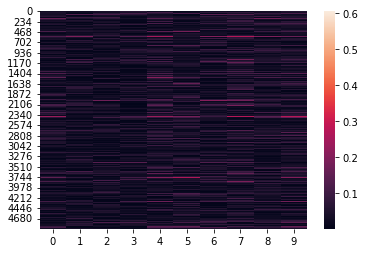

In [17]:
sns.heatmap(np.absolute(model.weights[0].numpy()))

In [18]:
data.index

Index(['AAMP', 'AAR2', 'AARS', 'AASDHPPT', 'AATF', 'ABAT', 'ABCA1', 'ABCA7',
       'ABCB7', 'ABCC10',
       ...
       'ZNHIT6', 'ZNRD2', 'ZPR1', 'ZRSR2', 'ZSCAN18', 'ZSCAN32', 'ZSWIM8',
       'ZXDC', 'ZYX', 'ZZEF1'],
      dtype='object', name='Unnamed: 0', length=4911)

In [19]:
# Identify genes that we've found as extremely important
lupus_probability = []

# For each gene, pretend that we only have this gene turned on, then calculate probability of having lupus.
genes = data.index
for pos, gene in enumerate(genes):
    input_val = np.zeros([1, len(genes)])
    input_val[0][pos] = 1
    probability = model.predict(input_val)[0][1]
    print(F"Gene {gene}: {probability}")
    lupus_probability.append([probability, gene])

1/1 [==============================] - 0s 22ms/step
Gene AAMP: 0.3196633458137512
1/1 [==============================] - 0s 20ms/step
Gene AAR2: 0.3109656274318695
1/1 [==============================] - 0s 20ms/step
Gene AARS: 0.3289109170436859
1/1 [==============================] - 0s 19ms/step
Gene AASDHPPT: 0.32053661346435547
1/1 [==============================] - 0s 25ms/step
Gene AATF: 0.3361315131187439
1/1 [==============================] - 0s 18ms/step
Gene ABAT: 0.3144630193710327
1/1 [==============================] - 0s 19ms/step
Gene ABCA1: 0.22827479243278503
1/1 [==============================] - 0s 20ms/step
Gene ABCA7: 0.30325940251350403
1/1 [==============================] - 0s 21ms/step
Gene ABCB7: 0.3048778474330902
1/1 [==============================] - 0s 20ms/step
Gene ABCC10: 0.29312318563461304
1/1 [==============================] - 0s 35ms/step
Gene ABCC5: 0.31388920545578003
1/1 [==============================] - 0s 17ms/step
Gene ABCD3: 0.34190401434898376

In [165]:
lupus_probability = np.array(sorted(lupus_probability, key=lambda x: -x[0]))
lupus_probability[:50][:,1]

array(['XIST', 'USP18', 'ITM2A', 'HERC5', 'ISG15', 'MMP9', 'TYMS',
       'SIRPB1', 'TMEM204', 'MT1E', 'IFITM3', 'COX16', 'ANXA3', 'MX1',
       'RPL24', 'IFITM2', 'TUBB6', 'LRP3', 'SGK1', 'PSMA6', 'EIF1B',
       'RSAD2', 'ERGIC2', 'IFI16', 'HMGB2', 'F8A3', 'BIRC3', 'UFL1',
       'TRAK2', 'S100A8', 'VNN1', 'DDX60', 'ABCA1', 'LGALS3BP', 'ERH',
       'OAS3', 'SLC36A1', 'GASK1B', 'LGALS1', 'PTTG1', 'TRPS1', 'SP140',
       'GAPDH', 'FABP5', 'SRBD1', 'ARID5B', 'RAB13', 'ACAP1', 'EIF2AK2',
       'TMSB10'], dtype='<U32')

In [83]:
print("\n".join(lupus_probability[:50][:,1]))

USP18
XIST
ISG15
HERC5
ITM2A
MMP9
TIMM10
RSAD2
SGK1
SIRPB1
MX1
CPT1B
TYMS
FABP5
COX16
BLOC1S1
LRP3
IFITM3
LGALS3BP
RPL24
EIF2AK2
LXN
SRBD1
TMEM204
MT1F
OAS3
MT1E
EIF1B
ABCA1
DPM1
CMC2
SPATS2L
LGALS1
HMBOX1
COMMD3
NDUFA1
IFITM2
PSMA6
PRDX4
TMSB10
RRM2
PTTG1
SLPI
RPS20
STAT4
IFI16
VNN1
HCP5
TRAK2
ARG1
